In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import scipy

import sklearn

### Metacritic game reviews

Data from [kaggle dataset](https://www.kaggle.com/dahlia25/metacritic-video-game-comments)

In [2]:
DATA_PATH = os.path.abspath('../data')
metacritic_game_info_path = os.path.join(DATA_PATH, 'metacritic_game_info.csv')
metacritic_game_comments_path = os.path.join(DATA_PATH, 'metacritic_game_user_comments.csv')

In [3]:
if not os.path.exists(os.path.abspath(metacritic_game_info_path)):
    !unzip ../data/metacritic-video-game-comments.zip -d ../data
    !chmod +rwx ../data/*csv 

In [4]:
def clean_game_dfs(game_info_df, game_comments_df):
    game_info_df = game_info_df[game_info_df['Metascore'] != 'not specified']
    game_info_df = game_info_df[game_info_df['Avg_Userscore'] != 'not specified']
    game_info_df = game_info_df[game_info_df['Avg_Userscore'] != 'tbd']
    
    for col in ['Metascore', 'Avg_Userscore', 'Year']:
        game_info_df[col] = game_info_df[col].astype('float')
    pc_game_info_df = game_info_df[game_info_df['Platform'] == 'PC']
    pc_game_comments_df = game_comments_df[game_comments_df['Title'].isin(pc_game_info_df['Title'])]
    return pc_game_info_df, pc_game_comments_df

In [5]:
game_info_df = pd.read_csv(metacritic_game_info_path, index_col='Unnamed: 0')
game_comments_df = pd.read_csv(metacritic_game_comments_path, index_col='Unnamed: 0')

pc_game_info_df, pc_game_comments_df = clean_game_dfs(game_info_df, game_comments_df)

In [6]:
pc_game_info_df.head()

,Title,Year,Publisher,Genre,Platform,Metascore,Avg_Userscore,No_Players
20,Half-Life 2,2004.0,ValveSoftware,Action;Shooter;Shooter;First-Person;Sci-Fi;Sci...,PC,96.0,9.1,No Online Multiplayer
21,Grand Theft Auto V,2015.0,RockstarNorth,Modern;Action Adventure;Open-World,PC,96.0,7.7,Up to 32
28,The Orange Box,2007.0,ValveSoftware,Action;Miscellaneous;Shooter;Compilation;First...,PC,96.0,9.2,16 Online
34,Half-Life,1998.0,ValveSoftware,Action;Shooter;Shooter;First-Person;Sci-Fi;Sci...,PC,96.0,9.1,1-32
38,BioShock,2007.0,"IrrationalGames,2KMarin",Action;Shooter;Shooter;First-Person;Sci-Fi;Sci...,PC,96.0,8.5,No Online Multiplayer


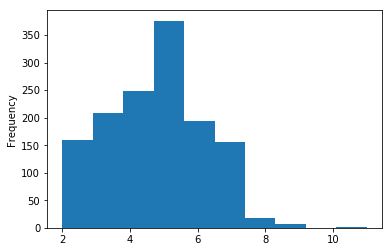

In [7]:
pc_game_info_df['Genre'].str.split(";").apply(len).plot.hist()

In [8]:
pc_game_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1368 entries, 20 to 4995
Data columns (total 8 columns):
Title            1368 non-null object
Year             1368 non-null float64
Publisher        1368 non-null object
Genre            1368 non-null object
Platform         1368 non-null object
Metascore        1368 non-null float64
Avg_Userscore    1368 non-null float64
No_Players       1367 non-null object
dtypes: float64(3), object(5)
memory usage: 96.2+ KB


In [9]:
pc_game_comments_df.shape

(187517, 5)

## Correlation between user and metascore

In [10]:
np.corrcoef(pc_game_info_df['Avg_Userscore'], pc_game_info_df['Metascore'])[0,1]

0.21381816860581535

### Spearman rank correlation coefficient

In [11]:
scipy.stats.spearmanr(pc_game_info_df['Avg_Userscore'], pc_game_info_df['Metascore'])

SpearmanrResult(correlation=0.2678004214955681, pvalue=6.729732567969086e-24)

### Average user vs metascore

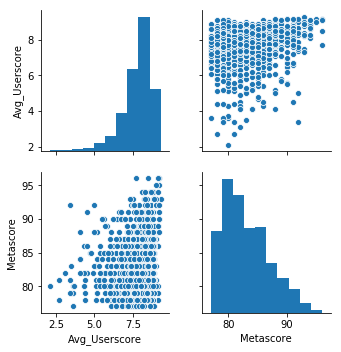

In [12]:
sns.pairplot(pc_game_info_df[['Avg_Userscore', 'Metascore']]);